In [1]:
import sys
sys.path.append("/home/johann/sonstiges/machine-learning-playground/src")

In [2]:
import torch 
import tqdm
import torch.nn as nn 
from torch.utils.data import DataLoader
from torchtext.data.metrics import bleu_score
from dataset import prepare_data, get_iter, Collater
from rnn_attn import build_model
from config import get_cfg_defaults
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

# Helper Functions

In [86]:
def translate(
    sentence: str, 
    model: torch.nn.Module, 
    cfg, 
    max_length: int, 
    text_transform: dict, 
    vocab_transform: dict, 
    token_transform: dict, 
    device: torch.device,
    plot: bool = True,
):
    """Function to translate a sentence and plot the attention weights."""
    model.eval()
    text_tensor = text_transform[cfg.DATASET.SRC_LANGUAGE](sentence)
    text_tensor = text_tensor.unsqueeze(1).to(device)
    
    with torch.no_grad():
        out, attn = model.inference(text_tensor, max_length, cfg)
    
    pred_tokens = out.argmax(2).squeeze(1)
    pred_tokens = [t.item() for t in pred_tokens]
    
    eos = pred_tokens.index(cfg.DATASET.EOS_IDX)
    
    translation = vocab_transform[cfg.DATASET.TGT_LANGUAGE].lookup_tokens(pred_tokens[1:eos])
    
    attn = attn.squeeze(0).cpu().numpy()
    attn = attn[1:eos+1, 1:] # [tgt, src]
    
    src_tokens = token_transform[cfg.DATASET.SRC_LANGUAGE](sentence)
    tgt_tokens = token_transform[cfg.DATASET.TGT_LANGUAGE](" ".join(translation))
    
    src_tokens += ["<eos>"]
    tgt_tokens += ["<eos>"]
    
    print("TRANSLATION")
    print("="*50)
    print("SOURCE: {}".format(" ".join(src_tokens)))
    print("-"*50)
    print("PREDICTION: {}".format(" ".join(translation)))
    print("\n")
    
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(10,10))

        img = ax.matshow(attn)
        ax.set_xticks([i for i in range(len(src_tokens))])
        ax.set_yticks([i for i in range(len(tgt_tokens))])

        ax.set_xticklabels(src_tokens, rotation=90)
        ax.set_yticklabels(tgt_tokens)

In [59]:
def print_test_predictions(
    model, 
    dataloader, 
    cfg, 
    vocab_transform, 
    device, 
    max_length: int = 100, 
    num_sentences: int = 5,
):
    model.eval()
    count = 0
    for src, tgt in test_dataloader:
        print("==="*20)
        src_ = src.to(device)

        with torch.no_grad():
            pred, _ = model.inference(src_, max_length, cfg)

        pred = pred.argmax(2).squeeze(1)
        pred = [t.item() for t in pred]
        eos = pred.index(cfg.DATASET.EOS_IDX)
        pred = pred[1:eos]
        pred = vocab_transform[cfg.DATASET.TGT_LANGUAGE].lookup_tokens(pred)

        src = list(src.squeeze(1).numpy())
        tgt = list(tgt.squeeze(1).numpy())

        src = vocab_transform[cfg.DATASET.SRC_LANGUAGE].lookup_tokens(src)
        tgt = vocab_transform[cfg.DATASET.TGT_LANGUAGE].lookup_tokens(tgt)

        print("SRC:\t{}".format(" ".join(src[1:-1])))
        print("TGT:\t{}".format(" ".join(tgt[1:-1])))
        print("---"*20)
        print("PRED:\t{}".format(" ".join(pred)))

        count += 1
        if count == num_sentences:
            return

In [61]:
def bleu_score_test(
    iterator, 
    model: torch.nn.Module, 
    cfg, 
    token_transform: dict, 
    text_transform: dict,
    vocab_transform: dict,
    max_n: int = 4, 
    weights: list = [0.25, 0.25, 0.25, 0.25],
    max_length: int = 1000,
):
    """Helper function to calculate bleu score."""
    bleu_scores = []
    model.eval()

    for src, tgt in tqdm.tqdm(iterator):
        src_ = token_transform[cfg.DATASET.SRC_LANGUAGE](src)
        tgt_ = token_transform[cfg.DATASET.TGT_LANGUAGE](tgt)
        # remove stuff for bleu score (I've chosen a bad tokenizer I guess)
        src_.remove('\n')
        while ' ' in src_:
            src_.remove(' ')
        while '  ' in src_:
            src_.remove('  ')
        while '   ' in src_:
            src_.remove('   ')
        tgt_.remove('\n')
        while ' ' in tgt_:
            tgt_.remove(' ')
        while '  ' in tgt_:
            tgt_.remove('  ')
        while '   ' in tgt_:
            tgt_.remove('   ')

        text_tensor = text_transform[cfg.DATASET.SRC_LANGUAGE](src)
        text_tensor = text_tensor.unsqueeze(1).to(device)

        with torch.no_grad():
            out, _ = model.inference(text_tensor, max_length, cfg)

        pred_tokens = out.argmax(2).squeeze(1)
        pred_tokens = [t.item() for t in pred_tokens]

        eos = pred_tokens.index(cfg.DATASET.EOS_IDX)
        pred_tokens_ = pred_tokens[1:eos]

        translation = vocab_transform[cfg.DATASET.TGT_LANGUAGE].lookup_tokens(pred_tokens_)

        while ' ' in translation:
            translation.remove(' ')
        while '  ' in translation:
            translation.remove('  ')
        while '   ' in translation:
            translation.remove('   ')

        candidate = [translation]
        refs = [[tgt_]]

        bscore = bleu_score(candidate, refs, max_n=max_n, weights=weights)
        bleu_scores.append(bscore)
        
    return round(sum(bleu_scores) / len(bleu_scores) * 100, 2)

In [4]:
# put your paths here
checkpoint_path = "/home/johann/sonstiges/machine-learning-playground/src/seq2seq_attn/experiments/2021-10-18_IWSLT2017/best.pth"
config_path = "/home/johann/sonstiges/machine-learning-playground/src/seq2seq_attn/experiments/2021-10-18_IWSLT2017/config.yaml"

In [5]:
cfg = get_cfg_defaults()
cfg.merge_from_file(config_path)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(1)

In [7]:
token_transform, vocab_transform, text_transform = prepare_data(cfg)

Length of vocab [de - IWSLT2017]: 16713
Length of vocab [en - IWSLT2017]: 14016


In [8]:
model = build_model(cfg, vocab_transform, device, checkpoint_path)
model.eval()

Load model checkpoint: /home/johann/sonstiges/machine-learning-playground/src/seq2seq_attn/experiments/2021-10-18_IWSLT2017/best.pth


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(16713, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(14016, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=14016, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [9]:
criterion = nn.CrossEntropyLoss(ignore_index=cfg.DATASET.PAD_IDX)
collater = Collater(cfg, text_transform)

In [10]:
test_iter = get_iter(cfg, split="test")

In [11]:
test_dataloader = DataLoader(test_iter, batch_size=1, collate_fn=collater, pin_memory=True)

In [60]:
print_test_predictions(model, test_dataloader, cfg, vocab_transform, device, max_length=100, num_sentences=7)

SRC:	Seitdem habe ich ungefähr 70 Workshops weltweit durchgeführt , mit Studenten , unk und Architekten , sogar mit unk der unk und da ist etwas an dieser Aufgabe , was tiefe Eindrücke in die Natur der Zusammenarbeit ermöglicht und ich möchte einige davon mit Ihnen teilen .
TGT:	And since then , I 've conducted   about 70 design workshops across the world   with students and designers and architects ,   even the unk of the Fortune 50 ,   and there 's something about this exercise   that reveals very deep lessons   about the nature of collaboration ,   and I 'd like to share some of them with you .
------------------------------------------------------------
PRED:	Since since I 've been around 70 of the world , with students , unk and architects , even with the unk of the , and there 's something about that that 's deep to to the the of of collaboration , and I want to share some of you share with some of you .
SRC:	Normalerweise starten die meisten Leute sich selbst bezüglich der Aufga

TRANSLATION
SOURCE: Mein Name ist Johann Gerberding und ich programmiere sehr gern und trainiere gern Machine Learning Modelle . <eos>
--------------------------------------------------
PREDICTION: My name is unk unk , and I love like to like to and I unk unk unk .




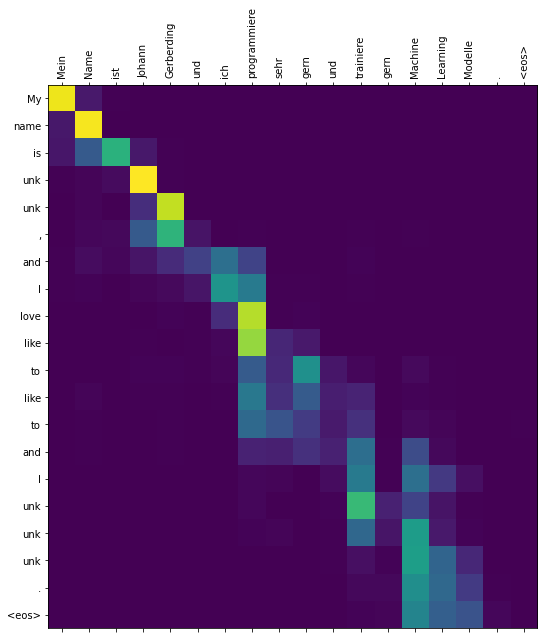

In [87]:
translate(
    "Mein Name ist Johann Gerberding und ich programmiere sehr gern und trainiere gern Machine Learning Modelle.",
    model,
    cfg, 
    100,
    text_transform,
    vocab_transform, 
    token_transform,
    device,
)

In [88]:
sentences = [
    "Er liebt Bücher und gutes Essen mehr als alles andere.", 
    "Mathematik und Physik waren seine liebsten Fächer in der Schule.",
    "Peter liebt es mit dem Fahrrad zur Arbeit zu fahren.",
    "Künstliche Intelligenz und programmieren macht einfach Spaß.",
]

TRANSLATION
SOURCE: Er liebt Bücher und gutes Essen mehr als alles andere . <eos>
--------------------------------------------------
PREDICTION: He loved books and good food than he was .




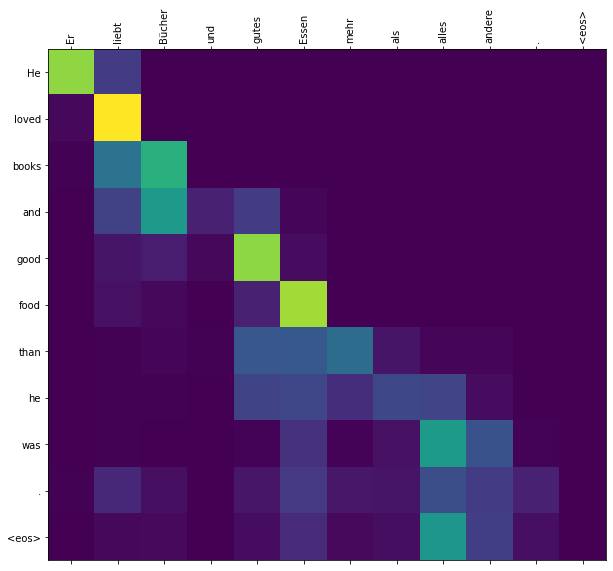

In [89]:
translate(sentences[0], model, cfg, 100, text_transform, vocab_transform, token_transform, device)

TRANSLATION
SOURCE: Mathematik und Physik waren seine liebsten Fächer in der Schule . <eos>
--------------------------------------------------
PREDICTION: unk and physics were were the best unk in school .




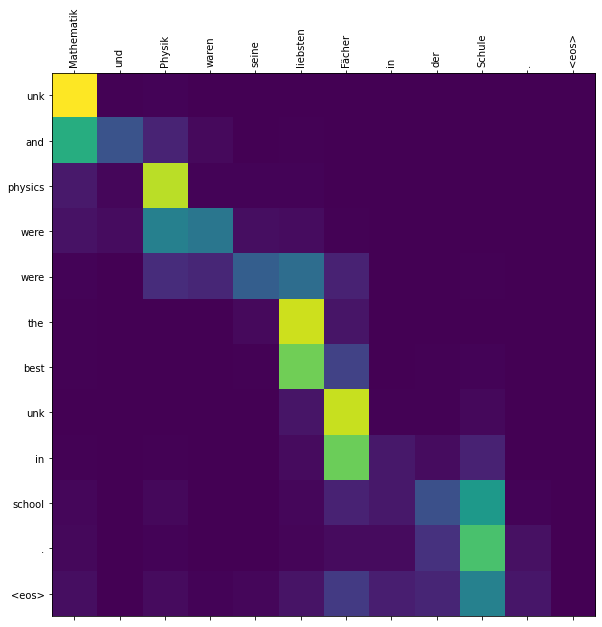

In [90]:
translate(sentences[1], model, cfg, 100, text_transform, vocab_transform, token_transform, device)

TRANSLATION
SOURCE: Peter liebt es mit dem Fahrrad zur Arbeit zu fahren . <eos>
--------------------------------------------------
PREDICTION: Peter Peter to drive to the bike to work .




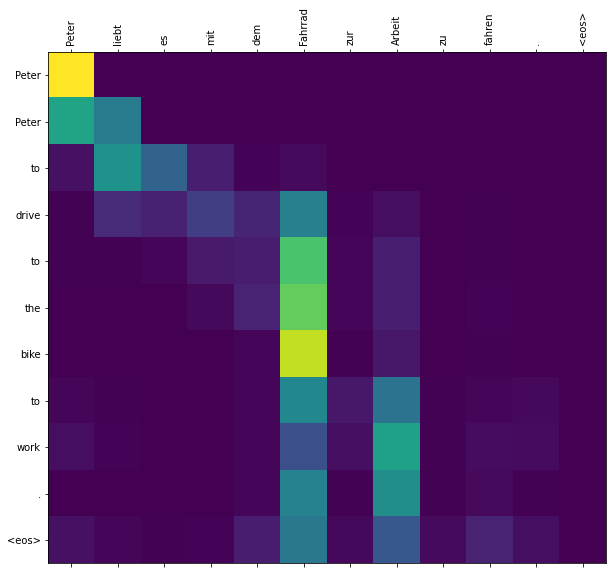

In [92]:
translate(sentences[2], model, cfg, 100, text_transform, vocab_transform, token_transform, device)

TRANSLATION
SOURCE: Künstliche Intelligenz und programmieren macht einfach Spaß . <eos>
--------------------------------------------------
PREDICTION: unk intelligence and code is just fun .




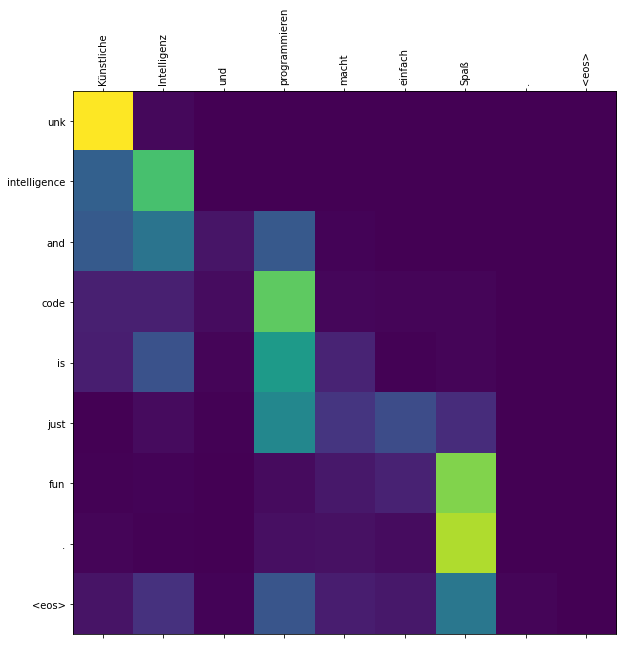

In [93]:
translate(sentences[3], model, cfg, 100, text_transform, vocab_transform, token_transform, device)

# Bleu Score

Down below I evaluate the model on the test set based on the Bleu Score (https://aclanthology.org/P02-1040.pdf) using two different ngram values, 3 & 4. The Bleu Score is often used for evaluation in Neural Machine Translation.

In [55]:
test_iter = get_iter(cfg, split="test")
bleu4 = bleu_score_test(
    test_iter,
    model, 
    cfg, 
    token_transform, 
    text_transform,
    vocab_transform)
bleu4

100%|████████████████████████████████████████████████████████████████████████████████████| 1568/1568 [10:07<00:00,  2.58it/s]


16.77

In [56]:
test_iter = get_iter(cfg, split="test")
bleu3 = bleu_score_test(
    test_iter,
    model, 
    cfg, 
    token_transform, 
    text_transform,
    vocab_transform,
    max_n=3,
    weights=[0.33, 0.33, 0.33])
bleu3

100%|████████████████████████████████████████████████████████████████████████████████████| 1568/1568 [10:09<00:00,  2.57it/s]


26.09